In [1]:
from typing import List

import einops
import torch
import torch.nn.functional as F
from IPython.display import display
from PIL import Image
from torch import nn
from torchvision import transforms
import matplotlib as plt
import numpy as np

In [2]:
import sys

sys.path.append('../')


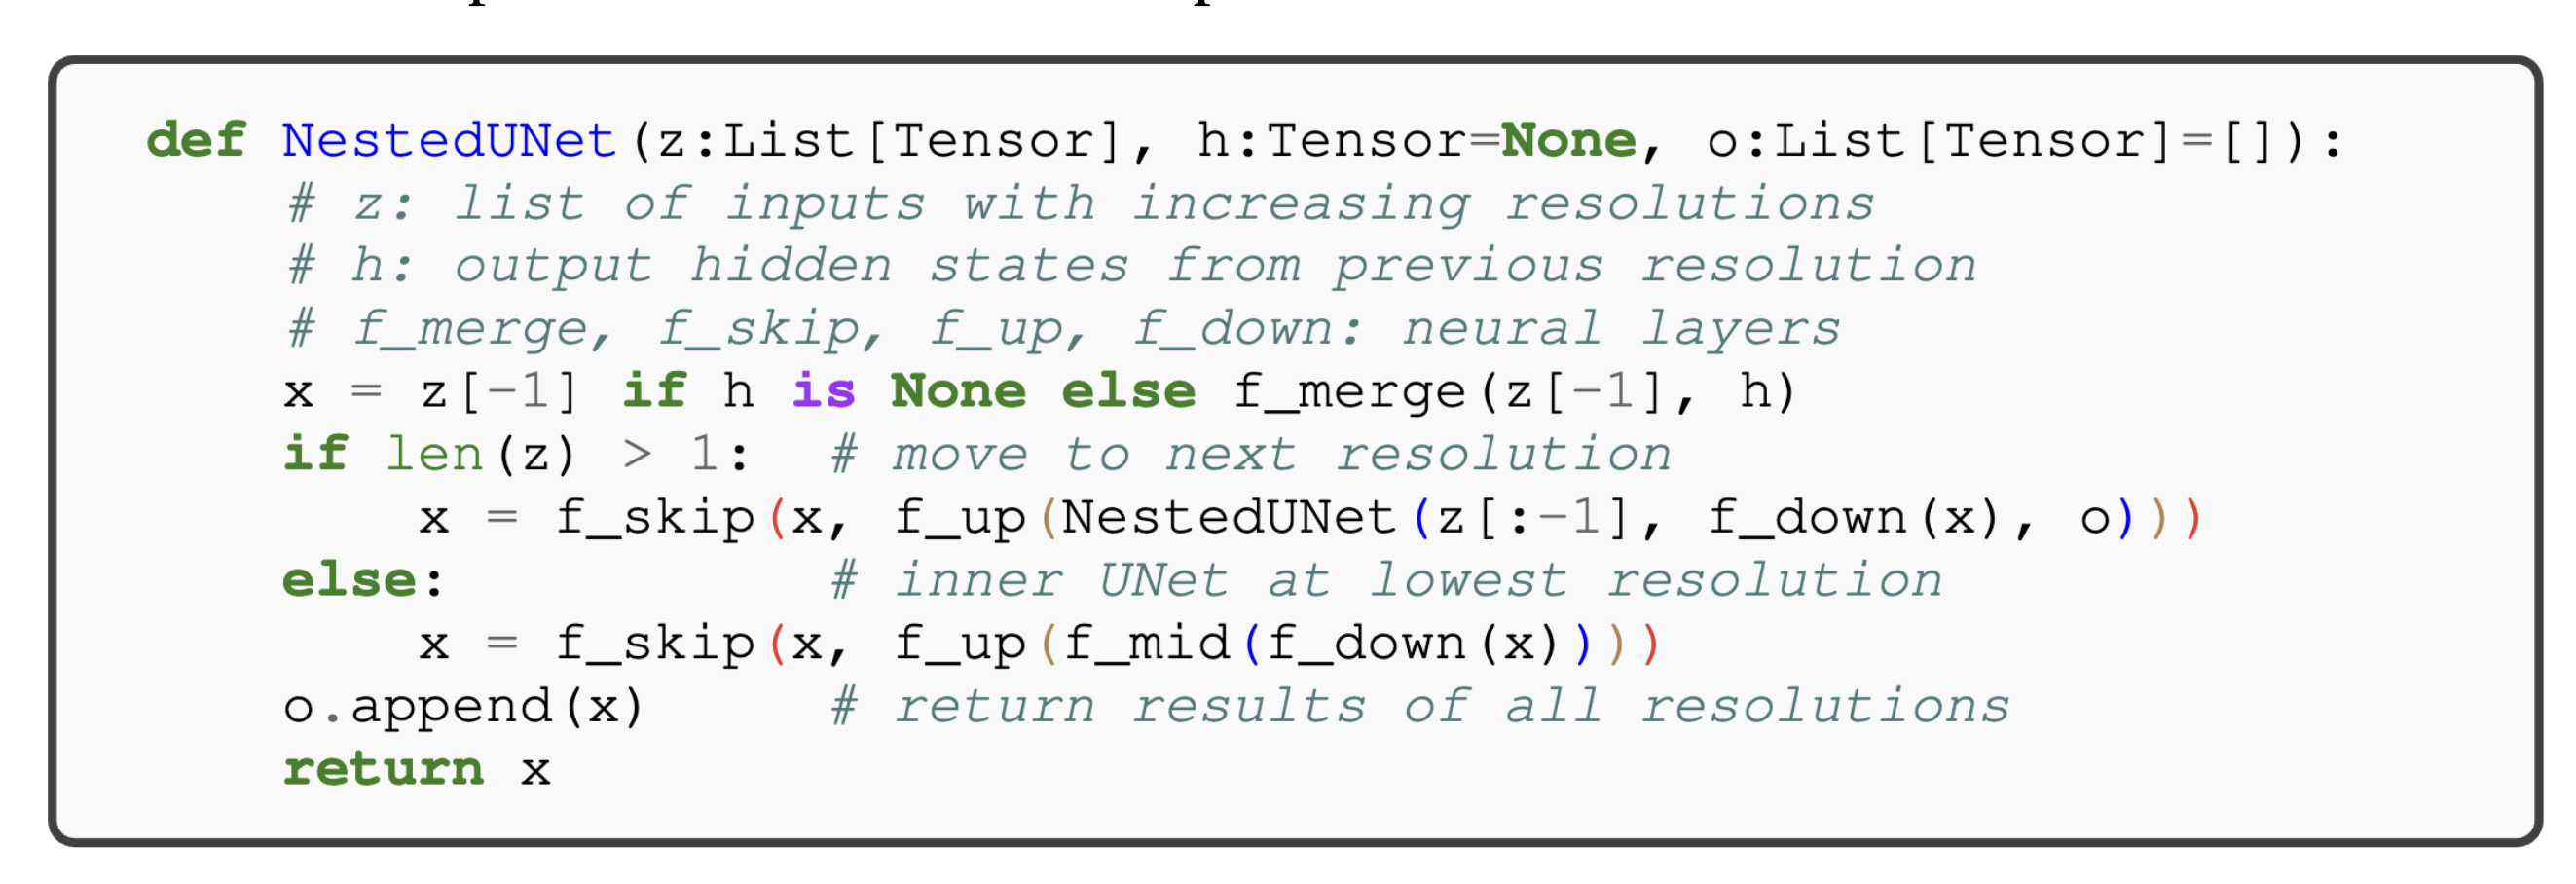

In [3]:
image = Image.open('imgs/nested_unet_img.png')
display(image)

### Flickr30k dataset

In [4]:
%env TOKENIZERS_PARALLELISM=False

env: TOKENIZERS_PARALLELISM=False


In [ ]:
IMAGE_SIZE = (64, 64)

In [ ]:
from torch.utils.data import DataLoader
import torchvision.transforms as T
from transformers import AutoTokenizer

from datasets.flickr30k.dataset import FlickrDataset

batch_size = 32

# Images normalized according to resnet 50 expectations (optional)
transforms = T.Compose([
    T.Resize(IMAGE_SIZE),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])

tokenizer = AutoTokenizer.from_pretrained('openai/clip-vit-base-patch32')

root = "../data/flickr30k/Images"
caps = "../data/flickr30k/captions.txt"
dataset = FlickrDataset(root, caps, transforms=transforms)


/home/byzovti/ysda/ysda-mdm/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


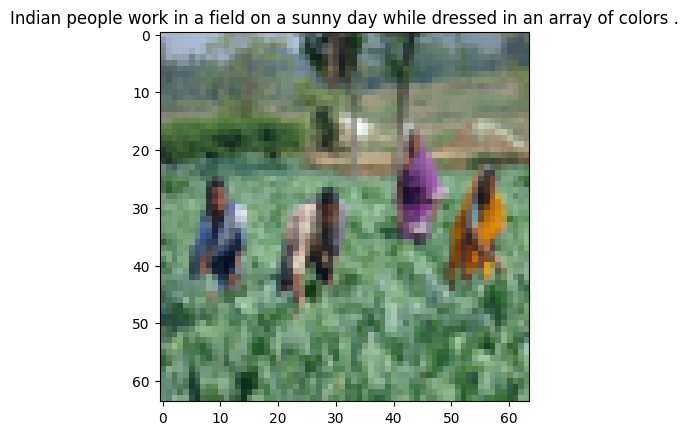

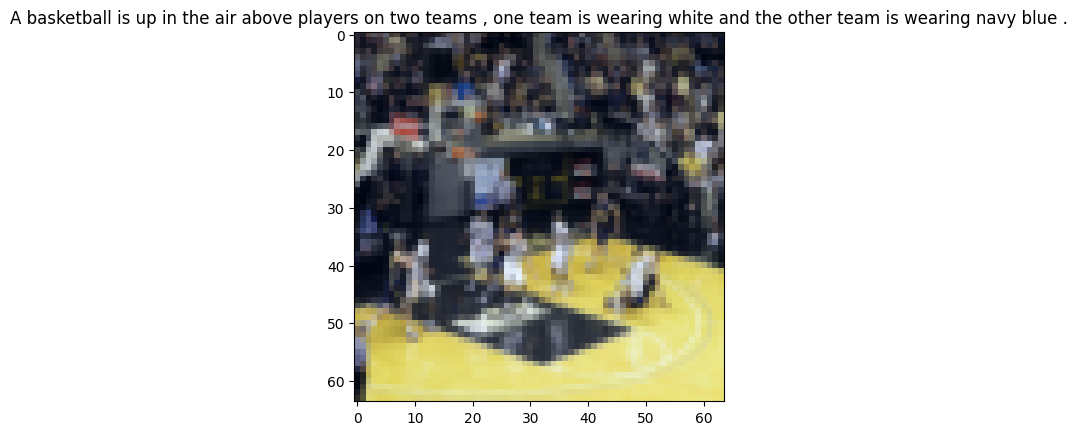

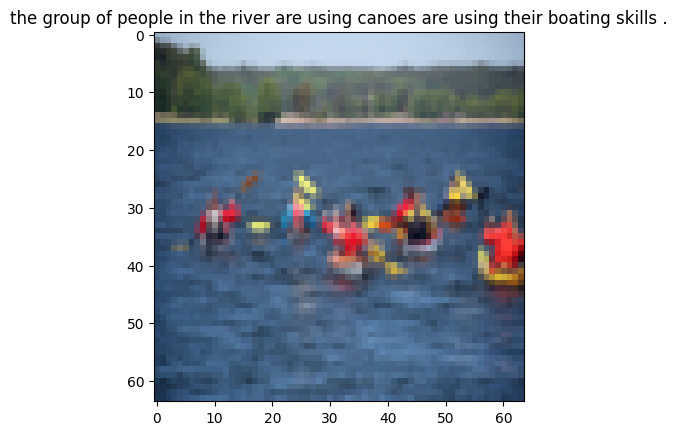

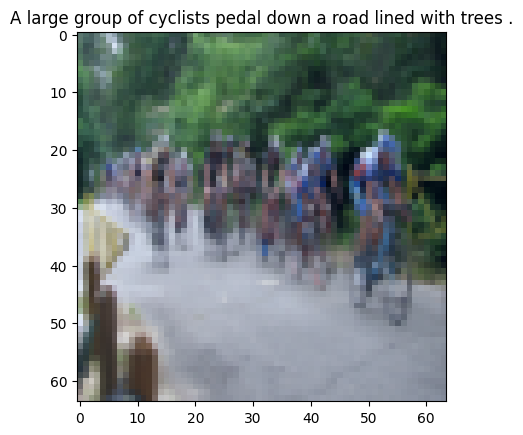

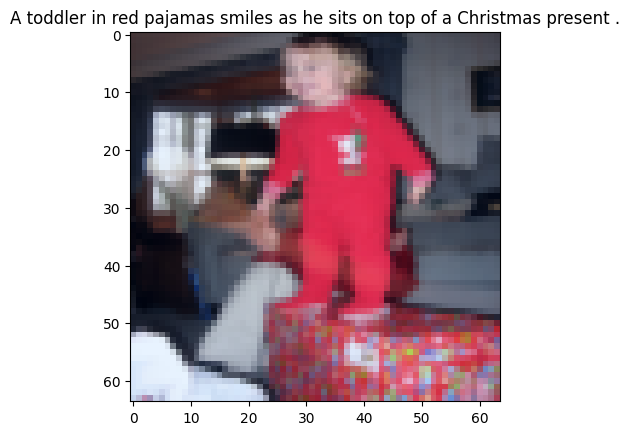

In [7]:
import matplotlib.pyplot as plt
import random

def show_img(img, caption):
    img = img.permute(1, 2, 0)  # Изменение формата с (C,H,W) на (H,W,C)
    plt.imshow(img)
    plt.title(caption)
    plt.show()


def show_samples_separately(dataset, num_samples=5):
    indices = random.sample(range(len(dataset)), num_samples)
    
    for idx in indices:
        item = dataset[idx]
        img = item['image']
        captions = item['captions']
        
        img = (img - img.min()) / (img.max() - img.min())
            
        show_img(img, captions[0][:200])

show_samples_separately(dataset)

#### conditioning prepare

In [8]:
class DiffusionCollator:
    def __init__(self, tokenizer, random_caption=True, max_cap_length=64):
        self.max_cap_length = max_cap_length
        self.tokenizer = tokenizer
        self.random_caption = random_caption
    
    def __call__(self, batch):
        batch_images = []
        batch_captions = []
        
        for item in batch:
            batch_images.append(item["image"])
            
            captions = item["captions"]
            caption_idx = random.randint(0, len(captions) - 1) if self.random_caption else 0
            batch_captions.append(captions[caption_idx])
            
        
        images = torch.stack(batch_images)

        tokenized = self.tokenizer(
            batch_captions,
            padding="max_length",
            max_length=self.max_cap_length,
            truncation=True,
            return_tensors="pt"
            )
                 
        return {
            'pixel_values': images,
            'captions_ids': tokenized.input_ids,
            'attention_mask': tokenized.attention_mask,
        }

In [ ]:
from helpers.lm import create_lm

tokenizer, encoder = create_lm("t5-small")

collator = DiffusionCollator(
    tokenizer,
    max_cap_length=64
)

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [10]:
from torch.utils.data import DataLoader

dataloader = DataLoader(
    dataset=dataset,
    batch_size=32,           # Размер батча
    shuffle=True,            # Перемешивать данные
    num_workers=4,           # Число процессов для загрузки данных
    collate_fn=collator
)


### MDM

Base architecture (MDM-S64)

config: resolutions=[64,32,16] resolution_channels =[256 ,512 ,768] num_res_blocks =[2 ,2 ,2] num_attn_layers_per_block =[0 ,1 ,5] num_heads=8, schedule=’cosine’ emb_channels=1024, num_lm_attn_layers =2 , lm_feature_projected_channels =1024


In [11]:
import math
import torch.nn as nn
import torch
import torch.nn.functional as F

In [12]:
def zero_module(module):
    for p in module.parameters():
        p.detach().zero_()
    return module

In [13]:
from dataclasses import dataclass, field

@dataclass
class ResNetConfig:
    in_channels: int = -1
    out_channels: int = -1
    num_groups_norm: int = 32
    dropout: float = 0.0
    use_attention_ffn: bool = False


@dataclass
class UNetConfig:
    resnet_config: ResNetConfig = field(default_factory=ResNetConfig)

    time_emb_dim: int = field(default=128)
    
    resolution_channels: list[int] = field(
        default_factory=lambda: [128, 256, 256, 512, 1024],
        metadata={"help": "Number of chanels on each block"}
    )
    
    num_resnets_per_resolution: list[int] = field(
        default_factory=lambda: [2, 2, 2, 2, 2],
        metadata={"help": "Number of residual used for each resolution"}
    )
    
    num_attention_layers: list[int] = field(
        default_factory=[0, 0, 1, 1, 0] ,
        metadata={"help": "Num of attention used for each block"}
    )
    
    conditioning_feature_dim: int = field(
        default=-1,
        metadata={"help": "Dimensions of conditioning vector for cross-attention"},
    )
    
    conditioning_feature_proj_dim: int = field(
        default=-1,
        metadata={"help": "If value > 0, lieanrly project the conditioning dimension"},
    )
    
    skip_mid_blocks: bool = field(default=False)
    
    nesting: bool = field(default=False)
    
    def __post_init__(self):
        assert len(self.num_attention_layers) == len(self.resolution_channels)
    
        assert len(self.num_resnets_per_resolution) == len(self.resolution_channels)
        

In [14]:
class ResNet(nn.Module):
    def __init__(self, time_emb_dim, config: ResNetConfig):
        super().__init__()
        self.config = config
        self.norm1 = nn.GroupNorm(config.num_groups_norm, config.in_channels)
        self.conv1 = nn.Conv2d(
            config.in_channels,
            config.out_channels,
            kernel_size=3,
            padding=1,
            bias=True,
        )
        self.time_layer = nn.Linear(time_emb_dim, config.out_channels * 2)
        self.norm2 = nn.GroupNorm(config.num_groups_norm, config.out_channels)
        self.dropout = nn.Dropout(config.dropout)
        self.conv2 = zero_module(
            nn.Conv2d(
                config.out_channels,
                config.out_channels,
                kernel_size=3,
                padding=1,
                bias=True,
            )
        )
        if self.config.out_channels != self.config.in_channels:
            self.conv3 = nn.Conv2d(
                config.in_channels, config.out_channels, kernel_size=1, bias=True
            )

    def forward(self, x, temb):
        h = F.silu(self.norm1(x))
        h = self.conv1(h)
        ta, tb = (
            self.time_layer(F.silu(temb)).unsqueeze(-1).unsqueeze(-1).chunk(2, dim=1)
        )
        
        # if h.size(0) > ta.size(0):  # HACK. repeat to match the shape.
        #     N = h.size(0) // ta.size(0)
        #     ta = einops.repeat(ta, "b c h w -> (b n) c h w", n=N)
        #     tb = einops.repeat(tb, "b c h w -> (b n) c h w", n=N)
        
        h = F.silu(self.norm2(h) * (1 + ta) + tb)
        h = self.dropout(h)
        h = self.conv2(h)
        if self.config.out_channels != self.config.in_channels:
            x = self.conv3(x)
        return h + x


In [15]:
class PixelsAttention(nn.Module):
    def __init__(
        self,
        channels,
        num_heads=8,
        num_head_channels=-1,
        
        cond_dim=None,
        
        use_attention_ffn=False,
    ):
        super().__init__()
        
        if num_head_channels == -1:
            self.num_heads = num_heads
        else:
            assert (
                channels % num_head_channels == 0
            ), f"q,k,v channels {channels} is not divisible by num_head_channels {num_head_channels}"
            self.num_heads = channels // num_head_channels
        
        self.norm = nn.GroupNorm(32, channels)
        self.qkv = nn.Conv2d(channels, channels * 3, 1)
        self.cond_dim = cond_dim

        if cond_dim is not None and cond_dim > 0:
            self.norm_cond = nn.LayerNorm(cond_dim)
            self.kv_cond = nn.Linear(cond_dim, channels * 2)

        self.proj_out = zero_module(nn.Conv2d(channels, channels, 1))
        if use_attention_ffn:
            self.ffn = nn.Sequential(
                nn.GroupNorm(32, channels),
                nn.Conv2d(channels, 4 * channels, 1),
                nn.GELU(),
                zero_module(nn.Conv2d(4 * channels, channels, 1)),
            )
        else:
            self.ffn = None

    def attention(self, q, k, v, mask=None):
        bs, width, length = q.shape
        ch = width // self.num_heads
        scale = 1 / math.sqrt(math.sqrt(ch))
        weight = torch.einsum(
            "bct,bcs->bts",
            (q * scale).reshape(bs * self.num_heads, ch, length),
            (k * scale).reshape(bs * self.num_heads, ch, -1),
        )  # More stable with f16 than dividing afterwards
        if mask is not None:
            mask = (
                mask.view(mask.size(0), 1, 1, mask.size(1))
                .repeat(1, self.num_heads, 1, 1)
                .flatten(0, 1)
            )
            weight = weight.masked_fill(mask == 0, float("-inf"))
        weight = torch.softmax(weight.float(), dim=-1).type(weight.dtype)
        a = torch.einsum("bts,bcs->bct", weight, v.reshape(bs * self.num_heads, ch, -1))
        return a.reshape(bs, -1, length)

    def forward(self, x, cond=None, cond_mask=None):
        # assert (self.cond_dim is not None) == (cond is not None)
        b, c, *spatial = x.shape
        # x = x.reshape(b, c, -1)
        qkv = self.qkv(self.norm(x))
        q, k, v = qkv.reshape(b, 3 * c, -1).chunk(3, dim=1)
        h = self.attention(q, k, v)
        if self.cond_dim is not None and self.cond_dim > 0:
            kv_cond = self.kv_cond(self.norm_cond(cond)).transpose(-2, -1)
            k_cond, v_cond = kv_cond.chunk(2, dim=1)
            h_cond = self.attention(q, k_cond, v_cond, cond_mask)
            h = h + h_cond
        h = h.reshape(b, c, *spatial)
        h = self.proj_out(h)
        x = x + h
        if self.ffn is not None:
            x = self.ffn(x) + x
        return x


In [16]:
class ResNetBlock(nn.Module):
    def __init__(
        self,
        time_emb_dim: int,
        num_residual_blocks: int,
        num_attention_layers: int,
        downsample_output: bool,
        upsample_output: bool,
        resnet_configs: list[ResNetConfig],
        cond_dim: int = -1,
    ):
        super().__init__()
        resnets = []
        self.num_residual_blocks = num_residual_blocks
        self.num_attention_layers = num_attention_layers
        self.upsample_output = upsample_output
        self.downsample_output = downsample_output
        
        assert (downsample_output and upsample_output) == False

        for i in range(num_residual_blocks):
            cur_config = resnet_configs[i]
            resnets.append(ResNet(time_emb_dim, cur_config))
        self.resnets = nn.ModuleList(resnets)

        if self.num_attention_layers > 0:
            attn = []
            for i in range(num_residual_blocks):
                for j in range(self.num_attention_layers):
                    attn.append(
                        PixelsAttention(
                            resnet_configs[i].out_channels,
                            cond_dim=cond_dim,
                            use_attention_ffn=resnet_configs[i].use_attention_ffn,
                        )
                    )
            self.attn = nn.ModuleList(attn)

        if self.downsample_output:
            self.resample = nn.Conv2d(
                resnet_configs[-1].out_channels,
                resnet_configs[-1].out_channels,
                kernel_size=3,
                stride=2,
                padding=1,
                bias=True,
            )

        elif self.upsample_output:
            self.resample = nn.Conv2d(
                resnet_configs[-1].out_channels,
                resnet_configs[-1].out_channels,
                kernel_size=3,
                stride=1,
                padding=1,
                bias=True,
            )

    def forward(
        self,
        x,
        temb,
        skip_activations=None,
        return_activations=False,
        conditioning=None,
        cond_mask=None,
    ):
        activations = []

        for i in range(self.num_residual_blocks):
            if skip_activations is not None:
                skip_input = skip_activations.pop(0)
                x = torch.cat((x, skip_input), axis=1)

            x = self.resnets[i](x, temb)

            if self.num_attention_layers > 0:
                L = self.num_attention_layers
                for j in range(L):
                    x = self.attn[i * L + j](x, conditioning, cond_mask)
            
            activations.append(x)

        if self.downsample_output or self.upsample_output:
            if self.upsample_output:
                x = F.interpolate(x.type(torch.float32), scale_factor=2).type(x.dtype)
            x = self.resample(x)
            activations.append(x)

        if not return_activations:
            return x
        return x, activations


In [17]:
import copy

class UNet(nn.Module):
    def __init__(self, input_channels: int, output_channels: int, config: UNetConfig):
        super().__init__()
        self.down_blocks = []
        self.config = config
        self.input_channels = input_channels
        self.output_channels = output_channels
        
        # we will overwrite config.conditioning_feature_dim if config.conditioning_feature_proj_dim is provided        
        self.input_conditioning_feature_dim = config.conditioning_feature_dim
        if (
            config.conditioning_feature_dim > 0
            and config.conditioning_feature_proj_dim > 0
        ):
            config.conditioning_feature_dim = config.conditioning_feature_proj_dim
            self.lm_proj = nn.Linear(
                self.input_conditioning_feature_dim, config.conditioning_feature_dim
            )

        self.time_emb_dim = (
            config.resolution_channels[0] * 4
            if config.time_emb_dim is None
            else config.time_emb_dim
        )

        half_dim = self.time_emb_dim // 8
        emb = math.log(10000) / half_dim  # make this consistent to the adm unet
        emb = torch.exp(torch.arange(half_dim, dtype=torch.float) * -emb)
        self.register_buffer("t_emb", emb.unsqueeze(0), persistent=False)

        self.temb_layer1 = nn.Linear(self.time_emb_dim // 4, self.time_emb_dim)
        self.temb_layer2 = nn.Linear(self.time_emb_dim, self.time_emb_dim)


        channels = config.resolution_channels[0]
        self.conv_in = nn.Conv2d(
            input_channels, channels, kernel_size=3, stride=1, padding=1, bias=True
        )
        skip_channels = [channels]
        num_resolutions = len(config.resolution_channels)
        self.num_resolutions = num_resolutions

        for i in range(num_resolutions):
            down_resnet_configs = []
            num_resnets_per_resolution = config.num_resnets_per_resolution[i]
            for _ in range(num_resnets_per_resolution):
                resnet_config = copy.copy(config.resnet_config)
                resnet_config.in_channels = channels
                resnet_config.out_channels = config.resolution_channels[i]
                skip_channels.append(resnet_config.out_channels)
                down_resnet_configs.append(resnet_config)
                channels = resnet_config.out_channels

            if i != num_resolutions - 1:
                # no downsampling here, so no skip connections.
                skip_channels.append(resnet_config.out_channels)

            num_attention_layers = self.config.num_attention_layers[i]
            
            self.down_blocks.append(
                ResNetBlock(
                    self.time_emb_dim,
                    num_resnets_per_resolution,
                    num_attention_layers,
                    downsample_output=i != num_resolutions - 1,
                    upsample_output=False,
                    resnet_configs=down_resnet_configs,
                    cond_dim=(
                        config.conditioning_feature_dim
                        if self.config.num_attention_layers[i] > 0
                        else -1
                    ),
                )
            )
            channels = resnet_config.out_channels

        # middle resnets keep the resolution.
        resnet_config = copy.copy(resnet_config)
        resnet_config.in_channels = channels
        resnet_config.out_channels = channels

        if not config.skip_mid_blocks:
            self.mid_blocks = [
                ResNetBlock(
                    self.time_emb_dim,
                    1,
                    True,  # attn
                    False,  # downsample
                    False,  # upsample
                    resnet_configs=[resnet_config],
                    cond_dim=config.conditioning_feature_dim,
                ),
                ResNetBlock(
                    self.time_emb_dim,
                    1,
                    False,  # attn
                    False,  # downsample
                    False,  # upsample
                    resnet_configs=[copy.copy(resnet_config)],
                ),
            ]

        self.up_blocks = []
        for i in reversed(range(num_resolutions)):
            up_resnet_configs = []
            num_resnets_per_resolution = config.num_resnets_per_resolution[i]
            for j in range(num_resnets_per_resolution + 1):
                resnet_config = copy.copy(config.resnet_config)
                resnet_config.in_channels = channels + skip_channels.pop()
                resnet_config.out_channels = config.resolution_channels[i]
                up_resnet_configs.append(resnet_config)
                channels = resnet_config.out_channels

            num_attention_layers = config.num_attention_layers[i]
            
            self.up_blocks.append(
                ResNetBlock(
                    self.time_emb_dim,
                    num_resnets_per_resolution + 1,
                    num_attention_layers,
                    downsample_output=False,
                    upsample_output=i != 0,
                    resnet_configs=up_resnet_configs,
                    cond_dim=(
                        config.conditioning_feature_dim
                        if self.config.num_attention_layers[i] > 0
                        else -1
                    ),
                )
            )
            channels = resnet_config.out_channels

        self.norm_out = nn.GroupNorm(config.resnet_config.num_groups_norm, channels)
        self.conv_out = zero_module(
            nn.Conv2d(channels, output_channels, kernel_size=3, padding=1)
        )

        self.down_blocks = nn.ModuleList(self.down_blocks)
        if not config.skip_mid_blocks:
            self.mid_blocks = nn.ModuleList(self.mid_blocks)
        self.up_blocks = nn.ModuleList(self.up_blocks)





    def create_time_emb(self, times, ff_layers=None):
        temb = times.view(-1, 1) * self.t_emb
        temb = torch.cat([torch.sin(temb), torch.cos(temb)], dim=1)
        if temb.shape[1] % 2 == 1:
            # zero pad
            temb = torch.cat([temb, torch.zeros(times.shape[0], 1)], dim=1)
        if ff_layers is None:
            layer1, layer2 = self.temb_layer1, self.temb_layer2
        else:
            layer1, layer2 = ff_layers
        temb = layer2(F.silu(layer1(temb)))
        return temb


    def forward_input_layer(self, x_t, normalize=False):
        if isinstance(x_t, list) and len(x_t) == 1:
            x_t = x_t[0]
        if normalize:
            x_t = x_t / x_t.std((1, 2, 3), keepdims=True)
        x = self.conv_in(x_t)
        return x

    def forward_output_layer(self, x):
        x_out = F.silu(self.norm_out(x))
        x_out = self.conv_out(x_out)
        return x_out

    def forward_downsample(self, x, temb, conditioning, cond_mask):
        skip_activations = [x]
        for i, block in enumerate(self.down_blocks):
            if self.config.num_attention_layers[i] > 0:
                x, activations = block(
                    x,
                    temb,
                    return_activations=True,
                    conditioning=conditioning,
                    cond_mask=cond_mask,
                )
            else:
                x, activations = block(x, temb, return_activations=True)
            skip_activations.extend(activations)
        return x, skip_activations

    def forward_upsample(self, x, temb, conditioning, cond_mask, skip_activations):
        num_resolutions = len(self.config.resolution_channels)
        for i, block in enumerate(self.up_blocks):
            ri = num_resolutions - 1 - i
            num_skip = self.config.num_resnets_per_resolution[ri] + 1
            skip_connections = skip_activations[-num_skip:]
            skip_connections.reverse()
            if self.config.num_attention_layers[ri] > 0:
                x = block(
                    x,
                    temb,
                    skip_activations=skip_connections,
                    conditioning=conditioning,
                    cond_mask=cond_mask,
                )
            else:
                x = block(x, temb, skip_activations=skip_connections)
            del skip_activations[-num_skip:]
        return x

    def forward_denoising(
        self, x_t, times, conditioning=None, cond_mask=None
    ):
        # 1. time embedding
        temb = self.create_time_emb(times)

        # 2. input layer
        if self.config.nesting:
            x_t, x_feat = x_t
        x = self.forward_input_layer(x_t)
        
        if self.config.nesting:
            x = x + x_feat

        # 3. downsample blocks
        x, skip_activations = self.forward_downsample(x, temb, conditioning, cond_mask)

        # 4. middle blocks
        if not self.config.skip_mid_blocks:
            x = self.mid_blocks[0](
                x, temb, conditioning=conditioning, cond_mask=cond_mask
            )
            x = self.mid_blocks[1](x, temb)

        # 5. upsample blocks
        x = self.forward_upsample(x, temb, conditioning, cond_mask, skip_activations)

        # 6. output layer
        x_out = self.forward_output_layer(x)
        if self.config.nesting:
            return x_out, x
        return x_out
    
    def forward_conditioning(self, conditioning):
        if self.config.conditioning_feature_proj_dim > 0:
            conditioning = self.lm_proj(conditioning)
        
        return conditioning


    def forward(
        self,
        x_t: torch.Tensor,
        times: torch.Tensor,
        conditioning: torch.Tensor = None,
        cond_mask: torch.Tensor = None,
    ) -> torch.Tensor:

        conditioning = self.forward_conditioning(conditioning)

        return self.forward_denoising(
            x_t, times, conditioning, cond_mask
        )

    @property
    def model_type(self):
        return "unet"


In [18]:
device='cuda:1'

In [19]:
resnet_config = ResNetConfig(
    num_groups_norm=32,
    dropout=0.0,
    use_attention_ffn=True,
)


unet_config = UNetConfig(
    resnet_config=resnet_config,
    resolution_channels=[32, 64],
    num_resnets_per_resolution=[1, 1],
    num_attention_layers=[0, 1],
    conditioning_feature_dim=512,
    conditioning_feature_proj_dim=2048,
    skip_mid_blocks=False,
    nesting=False,
)


unet = UNet(
    input_channels=3,      # Для RGB изображений
    output_channels=3,     # Сколько каналов должна предсказывать модель 
    config=unet_config,
).to(device)

In [20]:
batch_dict = next(iter(dataloader))

times = torch.ones(batch_dict['pixel_values'].shape[0])  # Все на одном временном шаге

with torch.no_grad():
    output = unet(
        x_t=batch_dict['pixel_values'].to(device),
        times=times.to(device),
        conditioning=encoder(batch_dict['captions_ids']).to(device),
        cond_mask=batch_dict['attention_mask'].to(device),
    )

print(f"Forward pass детка!")

Forward pass детка!


#### NestedUnet

In [21]:
@dataclass
class NestedUNetConfig(UNetConfig):
    inner_config: UNetConfig = field(
        default_factory=lambda: UNetConfig(nesting=True),
        metadata={"help": "inner unet used as middle blocks"},
    )
    skip_mid_blocks: bool = field(default=True)
    skip_inner_unet_input: bool = field(
        default=False,
        metadata={
            "help": "If enabled, the inner unet only received the downsampled image, no features."
        },
    )
    skip_normalization: bool = field(
        default=False,
    )
    freeze_inner_unet: bool = field(default=False)
    interp_conditioning: bool = field(
        default=False,
    )



In [22]:
class NestedUNet(UNet):
    def __init__(self, input_channels, output_channels, config: NestedUNetConfig):
        super().__init__(input_channels, output_channels=output_channels, config=config)
        config.inner_config.conditioning_feature_dim = config.conditioning_feature_dim
        if getattr(config.inner_config, "inner_config", None) is None:  # основной мув с вложенностью
            self.inner_unet = UNet(input_channels, output_channels, config.inner_config)
        else:
            self.inner_unet = NestedUNet(
                input_channels, output_channels, config.inner_config
            )

        if not config.skip_inner_unet_input:
            self.in_adapter = zero_module(
                nn.Conv2d(
                    config.resolution_channels[-1],
                    config.inner_config.resolution_channels[0],
                    kernel_size=3,
                    padding=1,
                    bias=True,
                )
            )
        else:
            self.in_adapter = None
            
        self.out_adapter = zero_module(
            nn.Conv2d(
                config.inner_config.resolution_channels[0],
                config.resolution_channels[-1],
                kernel_size=3,
                padding=1,
                bias=True,
            )
        )


        nest_ratio = int(2 ** (len(config.resolution_channels) - 1))
        if (
            self.inner_unet.config.nesting
            and self.inner_unet.model_type == "nested_unet"
        ):
            self.nest_ratio = [
                nest_ratio * self.inner_unet.nest_ratio[0]
            ] + self.inner_unet.nest_ratio
        else:
            self.nest_ratio = [nest_ratio]

        if config.freeze_inner_unet:
            for p in self.inner_unet.parameters():
                p.requires_grad = False
        if config.interp_conditioning:
            self.interp_layer1 = nn.Linear(self.time_emb_dim // 4, self.time_emb_dim)
            self.interp_layer2 = nn.Linear(self.time_emb_dim, self.time_emb_dim)


    def forward_conditioning(self, *args, **kwargs):
        return self.inner_unet.forward_conditioning(*args, **kwargs)

    def forward_denoising(
        self, x_t, times, conditioning=None, cond_mask=None
    ):
        # 1. time embedding
        temb = self.create_time_emb(times)

        # 2. input layer (normalize the input)
        if self.config.nesting:
            x_t, x_feat = x_t
        bsz = [x.size(0) for x in x_t]
        bh, bl = bsz[0], bsz[1]
        x_t_low, x_t = x_t[1:], x_t[0]
        x = self.forward_input_layer(
            x_t, normalize=(not self.config.skip_normalization)
        )
        if self.config.nesting:
            x = x + x_feat

        # 3. downsample blocks in the outer layers
        x, skip_activations = self.forward_downsample(
            x,
            temb[:bh],
            conditioning[:bh],
            cond_mask[:bh] if cond_mask is not None else cond_mask,
        )

        # 4. run inner unet
        x_inner = self.in_adapter(x) if self.in_adapter is not None else None
        x_inner = (
            torch.cat([x_inner, x_inner.new_zeros(bl - bh, *x_inner.size()[1:])], 0)
            if bh < bl
            else x_inner
        )  # pad zeros for low-resolutions
        x_low, x_inner = self.inner_unet.forward_denoising(
            (x_t_low, x_inner), times, conditioning, cond_mask
        )
        x_inner = self.out_adapter(x_inner)
        x = x + x_inner[:bh] if bh < bl else x + x_inner

        # 5. upsample blocks in the outer layers
        x = self.forward_upsample(
            x,
            temb[:bh],
            conditioning[:bh],
            cond_mask[:bh] if cond_mask is not None else cond_mask,
            skip_activations,
        )

        # 6. output layer
        x_out = self.forward_output_layer(x)

        # 7. outpupt both low and high-res output
        if isinstance(x_low, list):
            out = [x_out] + x_low
        else:
            out = [x_out, x_low]
        if self.config.nesting:
            return out, x
        return out


    @property
    def model_type(self):
        return "nested_unet"

In [ ]:
# Создание ResNetConfig для внешнего UNet
outer_resnet_config = ResNetConfig(
    in_channels=-1,
    out_channels=-1,
    num_groups_norm=32,
    dropout=0.0,
    use_attention_ffn=False
)

# Создание ResNetConfig для внутреннего UNet
inner_resnet_config = ResNetConfig(
    in_channels=-1,
    out_channels=-1,
    num_groups_norm=32,
    dropout=0.0,
    use_attention_ffn=True
)

# Создание UNetConfig для внутреннего UNet
inner_unet_config = UNetConfig(
    resnet_config=inner_resnet_config,
    time_emb_dim=128,  # Значение по умолчанию, т.к. temporal_dim=null в inner_config
    resolution_channels=[64, 128],
    num_resnets_per_resolution=[1, 1],
    num_attention_layers=[0, 1],   # TODO: провеить с attention
    conditioning_feature_dim=-1,
    conditioning_feature_proj_dim=-1,
    skip_mid_blocks=False,
    nesting=True
)

# Создание NestedUNetConfig
nested_unet_config = NestedUNetConfig(
    resnet_config=outer_resnet_config,
    time_emb_dim=1024,
    resolution_channels=[32, 64],
    num_resnets_per_resolution=[1, 1],
    num_attention_layers=[0, 1],
    conditioning_feature_dim=-1,
    conditioning_feature_proj_dim=-1,
    skip_mid_blocks=True,
    nesting=False,
    inner_config=inner_unet_config,
    skip_inner_unet_input=False,
    skip_normalization=True,
    freeze_inner_unet=False,
    interp_conditioning=False
)

nested_unet = NestedUNet(3, 3, nested_unet_config).to(device)

In [24]:
import torch
import torch.nn.functional as F


def create_image_pyramid(
    x: torch.Tensor,
    num_levels: int,    # включая оригинал
    device,
    scale_factor: int = 2,
) -> List[torch.Tensor]:
    pyramid = [x.to(device)]
    current = pyramid[-1]
    
    for _ in range(num_levels - 1):
        current = F.avg_pool2d(
            current,
            kernel_size=scale_factor,
            stride=scale_factor
        )
        pyramid.append(current.to(device))
    
    return pyramid

In [25]:
batch_dict = next(iter(dataloader))

times = torch.ones(batch_dict['pixel_values'].shape[0])
x_t = create_image_pyramid(batch_dict['pixel_values'], 2, device)

In [26]:
x_t[0].shape, x_t[1].shape

(torch.Size([32, 3, 64, 64]), torch.Size([32, 3, 32, 32]))

In [27]:
with torch.no_grad():
    output = nested_unet(
        x_t=x_t,
        times=times.to(device),
        conditioning=encoder(batch_dict['captions_ids']).to(device),
        cond_mask=batch_dict['attention_mask'].to(device),
    )

print(f"Forward pass детка!")

Forward pass детка!


#### Diffusion model

In [ ]:
from dataclasses import dataclass, field
from enum import Enum
from typing import Optional


class ScheduleType(Enum):
    DDPM = 2
    DEEPFLOYD = 3


class PredictionType(Enum):
    DDPM = 3
    V_PREDICTION = 5


class ThresholdType(Enum):
    CLIP = 1


@dataclass
class SimpleSamplerConfig:
    num_diffusion_steps: int = field(
        default=1000, metadata={"help": "Number of diffusion steps"}
    )
    schedule_type: ScheduleType = field(
        default=ScheduleType.DEEPFLOYD, metadata={"help": "Type of noise schedule"}
    )
    prediction_type: PredictionType = field(
        default=PredictionType.V_PREDICTION,
        metadata={"help": "Type of model prediction"},
    )
    beta_start: float = field(
        default=0.0001, metadata={"help": "Start beta for schedule"}
    )
    beta_end: float = field(default=0.02, metadata={"help": "End beta for schedule"})
    threshold_function: ThresholdType = field(
        default=ThresholdType.CLIP,
        metadata={"help": "Function for clipping x0 values"},
    )


@dataclass
class DiffusionConfig:
    sampler_config: SimpleSamplerConfig = field(
        default_factory=SimpleSamplerConfig,
        metadata={"help": "Basic configuration for the diffusion sampler"}
    )
    model_output_scale: float = field(
        default=0.0,
        metadata={"help": "Scale factor for model output"}
    )


In [ ]:
class DiffusionModel(nn.Module):
    def __init__(
        self, vision_model, diffusion_config: DiffusionConfig = DiffusionConfig()
    ):
        super().__init__()
        self.diffusion_config = diffusion_config
        self._output_scale = diffusion_config.model_output_scale
        self.vision_model = vision_model
        self.sampler = None

    def set_sampler(self, sampler: Sampler):
        self.sampler = sampler

    def load(self, vision_file: str) -> dict:
        return self.vision_model.load(vision_file)

    def save(self, vision_file, other_items=None):
        self.vision_model.save(vision_file, other_items=other_items)

    @property
    def input_channels(self):
        return self.vision_model.input_channels

    def forward(
        self,
        x_t: torch.Tensor,
        times: torch.Tensor,
        lm_outputs: torch.Tensor,
        lm_mask: torch.Tensor,
    ) -> tuple[torch.Tensor, torch.Tensor]:
        
        outputs = self.vision_model(x_t, times, lm_outputs, lm_mask)
        if self._output_scale != 0:
            outputs = torch.tanh(outputs / self._output_scale) * self._output_scale
        return outputs, torch.ones_like(outputs)


In [ ]:
class Diffusion(nn.Module):
    def __init__(self, denoising_model, diffusion_config: DiffusionConfig):
        super().__init__()
        logging.info(f"Diffusion config: {diffusion_config}")
        self.model = Model(denoising_model, diffusion_config)
        self.sampler = samplers.Sampler(diffusion_config.sampler_config)
        self.model.set_sampler(self.sampler)

        self._config = diffusion_config
        self.loss_fn = nn.MSELoss(reduction="none")

    def get_model(self):
        if hasattr(self.model, "module"):
            return self.model.module
        return self.model

    def to(self, device: torch.device):
        self.model = self.model.to(device)
        self.sampler = self.sampler.to(device)
        return self

    def train(self):
        self.model.train()

    def eval(self):
        self.model.eval()
        self.sampler.eval()

    def get_xt_minus_1(self, t, x_t, lm_outputs: torch.Tensor, lm_mask: torch.Tensor):
        self.eval()
        return self.sampler.get_xt_minus_1(t, x_t, lm_outputs, lm_mask)

    def get_pred_for_training(self, x_t, pred, g):
        if (
            self._config.sampler_config.loss_target_type
            == self._config.sampler_config.prediction_type
        ):
            return pred
        else:
            x0, _ = self.sampler.get_x0_eps_from_pred(
                x_t, pred, g, self._config.sampler_config.prediction_type
            )
            pred = self.sampler.get_pred_from_x0_xt(
                x_t, x0, g, self._config.sampler_config.loss_target_type
            )
            return pred

    def get_micro_conditioning(self, sample: dict) -> dict:
        micros, conditions = {}, self.get_model().vision_model.conditions
        if conditions is not None:
            micros = {key: sample[key] for key in conditions if key in sample}
        return micros

    def get_loss(self, sample: dict):
        images, lm_outputs, lm_mask = (
            sample["images"],
            sample["lm_outputs"],
            sample["lm_mask"],
        )

        # 1. get the parameters
        eps, g, g_last, weights, time = self.sampler.get_eps_time(images)
        if not self._config.use_vdm_loss_weights:
            weights = None

        x_t = self.sampler.get_xt(self.sampler.get_image_rescaled(images), eps, g)
        micros = self.get_micro_conditioning(sample)

        # 2. get model predictions
        means, variances = self.model(x_t, time, lm_outputs, lm_mask, micros)

        # 3. compute loss
        tgt = self.sampler.get_prediction_targets(
            images, eps, g, g_last, self._config.sampler_config.loss_target_type
        )
        pred = self.get_pred_for_training(x_t, means, g)
        loss = self.loss_fn(pred, tgt).mean(axis=(1, 2, 3))
        return loss, time, x_t, means, tgt, weights

    def get_noise(
        self,
        num_examples: int,
        input_channels: int,
        image_side: int,
        device: torch.device,
    ) -> torch.Tensor:
        return torch.randn(num_examples, input_channels, image_side, image_side).to(
            device
        )

    def sample(
        self,
        num_examples: int,
        sample: dict,
        image_side: int,
        device: torch.device,
        **kwargs: dict,
    ):
        self.eval()
        noise = self.get_noise(
            num_examples, self.get_model().input_channels, image_side, device
        )
        lm_outputs, lm_mask = sample["lm_outputs"], sample["lm_mask"]
        micros = self.get_micro_conditioning(sample)
        return self.sampler.sample(
            self.get_model(), noise, lm_outputs, lm_mask, micros, **kwargs
        )

    def partial_diffusion(
        self, images, t, lm_outputs, lm_mask, device, return_sequence=False
    ):
        self.eval()
        (_, x_t, _, _) = self.sampler.get_noisy_samples_for_training(images, t)
        return self.sampler.sample(
            x_t, lm_outputs, lm_mask, return_sequence=return_sequence, t=t
        )

### Попробуем в обучение сети

In [ ]:
from argparse import Namespace
from typing import Optional

import numpy as np
import torch
import torch.nn as nn

from torch.amp import GradScaler
from torch.utils.tensorboard import SummaryWriter
from torch.optim.lr_scheduler import LRScheduler

def train_batch(
    model: torch.nn.Module,
    sample: dict,
    optimizer: torch.optim.Optimizer,
    scheduler: LRScheduler,
    logger: Optional[SummaryWriter],
    args: Namespace,
    grad_scaler: Optional[GradScaler] = None,
    accumulate_gradient: bool = False,
    num_grad_accumulations: int = 1,
    ema_model: Optional[nn.Module] = None,
    loss_factor: float = 1.0,
):
    model.train()
    lr = scheduler.get_last_lr()[0]
    # Updates the scale for next iteration
    if args.fp16:
        with torch.amp.autocast(dtype=torch.bfloat16):
            losses, times, x_t, means, targets, weights = model.get_loss(sample)
            if weights is None:
                loss = losses.mean()
            else:
                loss = (losses * weights).sum() / weights.sum()
            loss = loss * loss_factor  # TODO: to simulate old behaviors
            loss_val = loss.item()

            if np.isnan(loss_val):
                optimizer.zero_grad()
                return loss_val, losses, times, x_t, means, targets

            if num_grad_accumulations != 1:
                loss = loss / num_grad_accumulations
        # Unscales gradients and calls or skips optimizer.step()
        grad_scaler.scale(loss).backward()

        if not accumulate_gradient:
            # Unscales the gradients of optimizer's assigned params in-place
            grad_scaler.unscale_(optimizer)
            # model.module.rescale_gradient_norms(args.gradient_clip_norm)
            total_norm = torch.nn.utils.clip_grad_norm_(
                model.model.parameters(), args.gradient_clip_norm
            ).item()
            grad_scaler.step(optimizer)
            grad_scaler.update()
            if ema_model is not None:
                ema_model.update(
                    getattr(model.model, "module", model.model).vision_model
                )
    else:
        losses, times, x_t, means, targets, weights = model.get_loss(sample)
        if weights is None:
            loss = losses.mean()
        else:
            loss = (losses * weights).sum() / weights.sum()
        loss_val = loss.item()
        if np.isnan(loss_val):
            # total_loss.backward() # is backward needed
            optimizer.zero_grad()
            optimizer.step()
            scheduler.step()
            return loss_val, losses, times, x_t, means, targets

        loss.backward()
        if num_grad_accumulations != 1:
            loss = loss / num_grad_accumulations
        if not accumulate_gradient:
            total_norm = nn.utils.clip_grad_norm_(
                model.parameters(), args.gradient_clip_norm
            ).item()
            optimizer.step()
            if ema_model is not None:
                ema_model.update(
                    getattr(model.model, "module", model.model).vision_model
                )

    if logger is not None and not accumulate_gradient:
        logger.add_scalar("train/Loss", loss_val)
        logger.add_scalar("lr", lr)

    if not accumulate_gradient:
        optimizer.zero_grad()
        scheduler.step()

    return loss_val, losses, times, x_t, means, targets
